#Imports 


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import h5py
from scipy import ndimage
import scipy
from PIL import Image
import copy
import time 
import math
import pickle
%matplotlib inline


#Implementaions

##Activation functions

###Forward pass

In [3]:
# Needed Functions 

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def softmax(Z):
  """
  Implement Softmax activation (Multi-class classification)

  Arguments:
  Z -- output of the linear layer

  Returns:
  A -- Post_activation parameter, the same shape as Z
  cache -- Z to use in backprop
  """

  t = np.exp(Z)
  A = t / np.sum(t, axis=0)
  
  assert(A.shape == Z.shape)

  cache = Z
  return A, cache

###Backward pass

In [4]:

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


##Initialization

###Weights

In [5]:
def initialize_parameters_deep(layer_dims, method='he'):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    method -- string; thte initialization mathod (zeros, random, he)
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):

        # zero initialization
        if method == 'zeros':
          parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))

        # random initialization 
        elif method == 'random':
          parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        
        # he initialization is recommended for relu activation layers
        elif method == 'he':
          parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2./layer_dims[l-1])

        # Initializaing bias to zeros is fine
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

###EMA

In [6]:
def initialize_EMA(parameters):
  """
  Initialize EMA (Exponentially moving averages)

  Arguments:
  parameters -- python dictionary, model weights 

  Returns:
  EMA -- python dictionary containing moving averages
  """

  L = len(parameters) // 2 # number of layers
  EMA ={} # 
  for l in range(L):
        EMA['VdW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape) # Same shape as parameters W1, ...
        EMA['Vdb' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape) # Same shape as parameters b1, ...

  return EMA

###RMS

In [7]:
def initialize_RMS(parameters):
  """
  Initialize RMS (Root mean squares)

  Arguments:
  parameters -- python dictionary, model weights 

  Returns:
  RMS -- python dictionary containing root mean squares
  """

  L = len(parameters) // 2 # number of layers
  RMS ={} # 
  for l in range(L):
        RMS['SdW' + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape) # Same shape as parameters W1, ...
        RMS['Sdb' + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape) # Same shape as parameters b1, ...

  return RMS

##Forward propagation

In [8]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    # linear calculation 
    Z = np.dot(W, A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    elif activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
def L_model_forward(X, parameters, keep_prob=1):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    keep_prob -- dropout probability
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    masks = {} # To save masks for dropout
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b'+ str(l)], activation='relu')
        A, masks['D' + str(l)] = dropout(A, keep_prob)
        caches.append(cache)

    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.    
    if parameters['W' + str(L)].shape[0] != 1:
      AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='softmax')

    else:
      AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (parameters['W' + str(L)].shape[0],X.shape[1]))
            
    return AL, caches, masks

##Cost function

In [11]:
def compute_cost(AL, Y, parameters=None, lambd=0):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    parameters -- to use in regularization term
    lamd -- regularization parameter

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1] # number of examples
    L2_regularization_cost = 0
    if isinstance(parameters, dict) and lambd:
      L = len(parameters) // 2  # Number of layers
      weights_square_sum = 0 # Sum of squared weights

      # Loop to sum all weights
      for l in range(L):
        weights_square_sum += np.sum(np.square(parameters['W' + str(l+1)])) 

      # Regularization term
      L2_regularization_cost = (lambd/(2*m)) * weights_square_sum

    # Compute loss from aL and y.
    if Y.shape[0] != 1:
      cross_entropy_cost = -1 / m * np.sum(Y * np.log(AL))
    else:
      cross_entropy_cost = -1 / m * np.sum(Y * np.log(AL) + (1-Y) * np.log(1-AL))

    # Cost 
    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

##Backward propagation

In [12]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1] # number of examples

    dW = 1. / m * np.dot(dZ, A_prev.T) # partial derivative of cost function w.r.t parameter W
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True) # partial derivative of cost function w.r.t parameter b
    dA_prev = np.dot(W.T, dZ) # partial derivative of cost function w.r.t A (previous layer output)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
def linear_activation_backward(dA, cache, activation, AL=None, Y=None):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    # Derivative w.r.t the activation
    if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)

  
    elif activation == "sigmoid":
      dZ = sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == 'softmax':
      dZ = AL - Y
      dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches, parameters, masks=None, keep_prob=1, lambd=0):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    parameters -- weights to use in regularization term
    lambd -- regularization parameter
    masks -- python dictionary containing masks used in dropout
    keep_prob -- number between 0 and 1 , probability of dropout 

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    if parameters['W' + str(L)].shape[0] != 1:
      grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 'softmax', AL=AL, Y=Y)
    else:  
      grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 'sigmoid')
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        if masks and (keep_prob != 1) and l > 0:
          grads["dA" + str(l)] = (dA_prev_temp * masks['D' + str(l)])/keep_prob
        else:
           grads["dA" + str(l)] = dA_prev_temp

        grads["dW" + str(l + 1)] = dW_temp + (lambd*parameters['W' + str(l+1)]/m)
        grads["db" + str(l + 1)] = db_temp

    return grads

##Learning rate update

In [15]:
def update_learning_rate(learning_rate0, epoch_num, decay_rate=1):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    
    learning_rate = learning_rate0 / (1 + decay_rate * epoch_num)
    
    return learning_rate

##Dropout

In [16]:
def dropout(A, keep_prob):
  """
  Drops out some hidden units to regularize 

  Arguments:
  A -- output of a layer 
  keep_prob -- probability of dropout

  returns:
  A_new -- the A matrix with applied dropout
  
  """
  D = np.random.randn(*A.shape) # creating a random array 
  D = (D < keep_prob) # set values to 0 (if larger than keep_prob) and 1 (if smaller than keep_prob)
  A_new = np.multiply(A, D) # shut down some values
  A_new = A_new / keep_prob # scale the values that haven't been shut down
  
  return A_new, D

## Update prameters

In [17]:
def update_parameters(parameters, grads, learning_rate, optimizer='gd', EMA=None, RMS=None, beta1=0.9, beta2=0.999, counter=None):
    """
    Update parameters using optimizer ('defualt: 'gradiend descent')
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    learning_rate -- small number (alpha)
    optimizer -- optimization algorithm ('gd', 'momentum', 'rmsprop', 'adam')
    EMA -- python dictionary containing exponentially (weighted) moving averages
    RMS -- python dictionary containing root mean squared (weighted) moving averages
    beta1 -- parameter for EMA (used in 'momentum' and 'adam')
    beta2 -- parameter for RMS (used in 'rmsprop' and 'adam')

    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    RMS, EMA -- python dictionary containing moving averages
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.

    # Gradient descent
    if optimizer == 'gd':
      for l in range(L):
          parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
          parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
      return parameters

    # Gradient descent with momentum
    elif optimizer == 'momentum':
      for l in range(L):
        # Compute exponentially (weighted) moving averages
        EMA['VdW' + str(l+1)] = np.multiply(beta1, EMA['VdW' + str(l+1)]) + np.multiply(1-beta1, grads['dW' + str(l+1)])
        EMA['Vdb' + str(l+1)] = np.multiply(beta1, EMA['Vdb' + str(l+1)]) + np.multiply(1-beta1, grads['db' + str(l+1)])
        
        # Update parameters
        parameters["W" + str(l+1)] -= learning_rate * EMA["VdW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * EMA["Vdb" + str(l+1)]
      return (parameters, EMA)
    
    # Root mean squared propagation
    elif optimizer == 'rmsprop':
      epsilon = 1e-8
      for l in range(L):
        # Compute root mean squared
        RMS['SdW' + str(l+1)] = beta2*RMS['SdW' + str(l+1)] + (1-beta2)*grads['dW' + str(l+1)]**2
        RMS['Sdb' + str(l+1)] = beta2*RMS['Sdb' + str(l+1)] + (1-beta2)*grads['db' + str(l+1)]**2

        # Update parameters
        parameters["W" + str(l+1)] -= (learning_rate * grads['dW' + str(l+1)]) / (np.sqrt(RMS["SdW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -= (learning_rate * grads['db' + str(l+1)]) / (np.sqrt(RMS["Sdb" + str(l+1)]) + epsilon) 
      return (parameters, RMS)
    
    # Adam optimization algorithm
    elif optimizer == 'adam':
      v_corrected = {} # Initializing first moment estimate, python dictionary
      s_corrected = {} # Initializing second moment estimate, python dictionary 
      epsilon = 1e-08
      for l in range(L):
        # Compute exponentially (weighted) moving averages
        EMA['VdW' + str(l+1)] = np.multiply(beta1, EMA['VdW' + str(l+1)]) + np.multiply(1-beta1, grads['dW' + str(l+1)])
        EMA['Vdb' + str(l+1)] = np.multiply(beta1, EMA['Vdb' + str(l+1)]) + np.multiply(1-beta1, grads['db' + str(l+1)])

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected"
        v_corrected["VdW" + str(l + 1)] = EMA["VdW" + str(l + 1)] / (1 - beta1**counter)
        v_corrected["Vdb" + str(l + 1)] = EMA["Vdb" + str(l + 1)] / (1 - beta1**counter)

        # Compute root mean squared
        RMS['SdW' + str(l+1)] = beta2*RMS['SdW' + str(l+1)] + (1-beta2)*grads['dW' + str(l+1)]**2
        RMS['Sdb' + str(l+1)] = beta2*RMS['Sdb' + str(l+1)] + (1-beta2)*grads['db' + str(l+1)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected"
        s_corrected["SdW" + str(l + 1)] = RMS["SdW" + str(l + 1)] / (1 - beta2**counter)
        s_corrected["Sdb" + str(l + 1)] = RMS["Sdb" + str(l + 1)] / (1 - beta2**counter)

        # Update parameters
        parameters["W" + str(l+1)] -= (learning_rate * v_corrected["VdW" + str(l+1)]) / (np.sqrt(s_corrected["SdW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -= (learning_rate * v_corrected["Vdb" + str(l+1)]) / (np.sqrt(s_corrected["Sdb" + str(l+1)]) + epsilon)
      return (parameters, EMA, RMS)


##Gradient check

In [18]:
def gradient_check(X, Y, layers_dims, epsilon=1e-7, print_iter=False):
  """
  Checks if the gradient computing (back propagation) is working properly

  Arguments:
  X --> data (inputs), numpy array of size (number of examples, num_px * num_px * 3)
  Y --> Ground truth labels, a numpy array of size (1, number of examples)
  layer_dims --> dimension of our network, python list
  epsilon --> a small number to use in derivative 
  print_iter --> print iterated number each print_iter iterations, False to not print, number to print

  Returns:
  diff --> difference of computed gradients, real number
  error --> the difference of diff and epsilon
  """
  parameters = initialize_parameters_deep(layers_dims)

  L = len(parameters) // 2 # number pf layers 

  AL, caches, _ = L_model_forward(X, parameters)
  grads =  L_model_backward(AL, Y, caches, parameters)
  dtheta = to_vector(grads)

  shapes = get_shapes(parameters) # get the shapes
  size = 0 # size of column vector
  
  for shape in shapes:
    size += shape[0] * shape[1]

  dtheta_approx = np.zeros((size,1)) # initialize vector of zeros
  assert(dtheta.shape == dtheta_approx.shape)
  
  print(size)
  for i in range(size):
    if print_iter:
      if i % print_iter == 0:
        print(i)
    theta = to_vector(parameters)

    # add the epsilon
    theta[i] += epsilon

    # turn to object
    params = from_vector(theta, shapes)

    # forward propagation
    AL, caches, _ = L_model_forward(X, params)

    # compute cost 
    cost_pos = compute_cost(AL, Y)

    # subtract the epsilon
    theta[i] -= 2 * epsilon

    # turn to object
    params = from_vector(theta, shapes)
    assert(theta.shape == dtheta_approx.shape)
    
    # forward propagation
    AL, caches, _ = L_model_forward(X, params)

    # compute cost 
    cost_neg = compute_cost(AL, Y)

    # assign to dtheta_approx
    dtheta_approx[i] = (cost_pos - cost_neg) / (2 * epsilon)

  assert(dtheta.shape == dtheta_approx.shape)
  # Compute the difference of calculated gradients
  diff = np.linalg.norm(dtheta_approx - dtheta) / (np.linalg.norm(dtheta_approx) + np.linalg.norm(dtheta))
  error = np.linalg.norm(epsilon - diff) # Error w.r.t epsilon

  if diff > 2e-7:
    print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(diff) + "\033[0m")
  else:
    print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(diff) + "\033[0m")
  return diff, error

In [19]:
def get_shapes(parameters):
  """
  Gets the shapes of the paramters 

  Arguments:
  parameters --> an object containing all the parameters W1, b1 , ....

  Retruns:
  shapes --> python list containing all parameters shapes
  """
  shapes = [] # save shapes for later use
  L = len(parameters) // 2 # number of layers 

  for l in range(L):
    shapes.append(parameters['W' + str(l+1)].shape)
    shapes.append(parameters['b' + str(l+1)].shape)
  
  return shapes


In [20]:
def to_vector(parameters):
  """
  Gets all the parameters and turns them into a column vector

  Arguments:
  parameters --> an object containing all the parameters W1, b1 , ....

  Returns:
  theta --> the column vector containing parameters 
  """

  L = len(parameters) // 2 # number of layers 
  vectors = []
  for l in range(L):
    if 'W' + str(l+1) in parameters:
      # append parameters (W, b) of layer l to vectors
      # array.reshape(-1, 1) reshapes as a column vector
      vectors.append(parameters['W' + str(l+1)].reshape(-1,1)) 
      vectors.append(parameters['b' + str(l+1)].reshape(-1,1))

    elif 'dW' + str(l+1) in parameters:
      # append grads (dW, db) of layer l to vectors
      # array.reshape(-1, 1) reshapes as a column vector
      vectors.append(parameters['dW' + str(l+1)].reshape(-1,1))
      vectors.append(parameters['db' + str(l+1)].reshape(-1,1))
      
  theta = np.concatenate(vectors, axis=0) # concatenate vectors

  return theta

In [21]:
def from_vector(theta, shapes):
  """
  Turns theta column vector to previous arrays with previous shapes

  Arguments:
  theta --> column vector containing all parameters , numpy array
  shapes --> python list with tupled shapes in each index refering to the parameters 

  Returns:
  parameters --> python object containing all parameters W1, ..... 
  """
  shapes = copy.deepcopy(shapes)
  parameters = {}
  L = len(shapes) // 2 # Number of layers

  for l in range(L):
    shape = shapes.pop(0) # shape of parameter W of layer l
    parameters['W' + str(l+1)] = theta[0:shape[0]*shape[1]].reshape(shape) # reshape as orignial shape
    theta = theta[shape[0]*shape[1]:] # eleminate the processed part

    shape = shapes.pop(0) # shape of parameter b of layer l
    parameters['b' + str(l+1)] = theta[0:shape[0]*shape[1]].reshape(shape) # reshape as orignial shape
    theta = theta[shape[0]*shape[1]:] # eleminate the processed part

  return parameters
  

##Mini_batch

In [22]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    C = Y.shape[0]
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((C,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

##Multi-Layer Perceptron

In [23]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, optimizer='gd', initialization='he', mini_batch_size=64, learning_rate=0.0075,
                  epochs=3000, print_cost=False,keep_prob=1, lambd=0, decay=None, decay_rate=1):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    optimizer -- optimization algorithm ('gd', 'momentum', 'rmsprop', 'adam')
    initialization -- method of initializing parameters ('zero', 'random', 'he')
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    decay -- function to update learning rate
    decay_rate -- rate of decaying the learning rate , scalar
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    # Alerting the type of optimization based on mini_batch_size
    message = 'Batch' if mini_batch_size == X.shape[1] else ('Stochastic' if mini_batch_size == 1 else 'mini-batch')
    print(message + ' Gradient Descent')
    
    np.random.seed(1)
    seed = 10 # Seed
    minibatches = random_mini_batches(X, Y, mini_batch_size, seed) # mini_batch

    t = 0 # Moving Average counter

    costs = [] # keep track of cost
    learning_rate0 = learning_rate # Saving the initial learning rate
    
    # Parameters initialization. 
    parameters = initialize_parameters_deep(layers_dims, method=initialization)
    L = len(parameters) // 2

    # Check the optimizer and initializing the requirements
    # Gradient descent with momentum
    if optimizer == 'momentum' or optimizer == 'adam':
      EMA = initialize_EMA(parameters) # Exponenetially (weighted) moving averages
      
    # Root mean square propagation
    if optimizer == 'rmsprop' or optimizer == 'adam':
      RMS  = initialize_RMS(parameters) # Root mean square
      
    
    # Loop (gradient descent)
    for i in range(0, epochs):
      seed += 1
      if message == 'mini-batch':
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

      for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches, masks = L_model_forward(minibatch_X, parameters, keep_prob=keep_prob)
        
        # Compute cost.
        cost = compute_cost(AL, minibatch_Y, parameters=parameters, lambd=lambd)
    
        # Backward propagation.
        grads = L_model_backward(AL, minibatch_Y, caches, parameters,masks=masks, keep_prob=keep_prob, lambd=lambd)

        # Update parameters.
        if optimizer == 'gd':
          parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == 'momentum':
          parameters, EMA = update_parameters(parameters, grads, learning_rate, optimizer='momentum', EMA=EMA)
        elif optimizer == 'rmsprop':
          parameters, RMS = update_parameters(parameters, grads, learning_rate, optimizer='rmsprop', RMS=RMS)
        elif optimizer == 'adam':
          t += 1
          parameters, EMA, RMS = update_parameters(parameters, grads, learning_rate, optimizer='adam', RMS=RMS, EMA=EMA, counter=t)
      
      # Learning rate decay
      if decay:
        learning_rate = decay(learning_rate0, i, decay_rate)

      # Print the cost every 100 training example
      if print_cost and i % print_cost == 0:
          print ("Cost after epoch %i: %f" %(i, cost), end=' ')
          costs.append(cost)
          if decay:
            print(f'|| Learning rate: {learning_rate}')
            
    # plot the 
    if print_cost:
      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.title("Learning rate =" + str(learning_rate))
      plt.show()
    
    return parameters

## Predict

In [24]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    
    # Forward propagation
    y_hat, caches, masks = L_model_forward(X, parameters)
  
    # convert probas to 0/1 predictions
    p = np.argmax(y_hat,axis=0).reshape(1,-1)

    # inverse the one hot encode
    y = np.argmax(y, axis=0).reshape(1,-1)

    # count the correctly predicted 
    true_count = (p == y).sum()
    print(f'Correctly predicted: {true_count}')
    print("Accuracy: "  + str(true_count / y.shape[1] * 100))
        
    return p

##Predict one example

In [25]:
def predict_one(parameters, path):
  """
  Predicts one input from a path 

  Arguments:
  x -- 
  parameters -- learned weights 
  path -- path to get picture from

  Returns:
  predicted_image -- predicted label
  """
  num_px = int(np.square(parameters['W1'].shape[1]))
  image = np.array(plt.imread(path))
  plt.imshow(image)
  image = np.array(Image.fromarray(image).resize(size=(num_px, num_px))).reshape((num_px*num_px,1))
  image /= 255.
  predicted_image = predict(image, [1], parameters)

  return predicted_image



## Load data

In [26]:

# Cat non-Cat data set
def load_cat_data():
  """
  Loads cat dataset

  Arguments:
  ----

  Returns:
  X_train_orig -- matrix of train set features
  y_train_orig -- matrix of train set labels
  X_test_orig -- matrix of test set features
  y_test_orig -- matrix of test set labels
  classes -- array of all classes
  """
  from google.colab import drive
  drive.mount('/content/drive')

  train_dataset = h5py.File('/content/drive/MyDrive/Datasets/cat_noncat/train_catvnoncat.h5', "r")
  X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
  y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('/content/drive/MyDrive/Datasets/cat_noncat/test_catvnoncat.h5', "r")
  X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
  y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  
  y_train = y_train.reshape((1, y_train.shape[0]))
  y_test = y_test.reshape((1, y_test.shape[0]))
  
  return X_train, y_train, X_test, y_test, classes


# MNIST (digits) dataset
def load_MNIST_data():
  """
  Loads the MNIST dataset (Multi-class)

  Arguments:
  -------

  Returns:
  X_train -- matrix of train set features
  y_train -- matrix of train set labels
  X_test -- matrix of test set features
  y_test -- matrix of test set labels
  classes -- array of all classes
  """
  df_train = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
  df_test = pd.read_csv('sample_data/mnist_test.csv', header=None)

  X_train = np.array(df_train.drop([0], axis=1)) # Train set features
  X_train = X_train.reshape(X_train.shape[0], 28,28)
  y_train = np.array(df_train[0]).reshape(1,-1) # Train set labels
  X_test = np.array(df_test.drop([0], axis=1)) # Test set features
  X_test = X_test.reshape(X_test.shape[0], 28,28)
  y_test = np.array(df_test[0]).reshape(1,-1) # Test set labels

  classes = np.unique(y_test) # All the classes

  return X_train, y_train, X_test, y_test, classes



##Save and Load model

In [27]:
def save_model(parameters, path):
  """
  pickes the model paramters for later use 


  Arguments:
  paramters -- model weights, python dictionary
  path -- path to save model in (picke file), string

  Returns:
  None
  """
  with open(path, 'wb') as f:
    pickle.dump(parameters, f, protocol=pickle.HIGHEST_PROTOCOL)
  

In [28]:
def load_model(path):
  """
  Loads model from given path 

  Arguments:
  path -- string, path to get model 

  Returns:
  parameters -- model parameters 
  """

  with open(path, 'rb') as f:
    parameters = pickle.load(f)

  return parameters

#Data analysis

It's the digit 2 


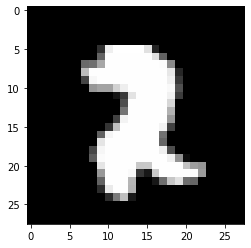

In [29]:
X_train, y_train, X_test, y_test, classes = load_MNIST_data()
# Example of a picture
index = 10
if len(classes) == 2:
  plt.imshow(X_train[index])
  print ("y = " + str(y_train[0,index]) + ". It's a " + classes[y_train[0,index]].decode("utf-8") +  " picture.")
else:
  plt.imshow(X_train[index], cmap='gray')
  print(f'It\'s the digit {y_train[0,index]} ')

###Exploring dataset

In [30]:
# Explore your dataset 
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))


Number of training examples: 20000
Number of testing examples: 10000
Each image is of size: (28, 28, 3)
X_train shape: (20000, 28, 28)
y_train shape: (1, 20000)
X_test shape: (10000, 28, 28)
y_test shape: (1, 10000)


###Reshaping and normalizing

In [31]:
# Reshape the training and test examples 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

print ("X_train's shape: " + str(X_train.shape))
print ("X_test's shape: " + str(X_test.shape))

X_train's shape: (784, 20000)
X_test's shape: (784, 10000)


###Label Encoding

In [32]:
if len(classes) > 2:
  # Encoding labels
  lb = LabelBinarizer()
  y_train = lb.fit_transform(y_train.T).T
  y_test = lb.fit_transform(y_test.T).T
  print("New shapes:")
  print('y_train dimension: ' + str(y_train.shape))
  print('y_test dimension: ' + str(y_test.shape))

New shapes:
y_train dimension: (10, 20000)
y_test dimension: (10, 10000)


#Applying Gradient check

In [33]:
# shrink the data to use in gradient check
x_grad_check = X_train[:700,:200] 
y_grad_check = y_train[:,:200]
print('x shape:' + str(x_grad_check.shape))
print('y shape:' + str(y_grad_check.shape))

x shape:(700, 200)
y shape:(10, 200)


In [34]:
dims = [700, 20, 10]
# prob, diff = gradient_check(x_grad_check, y_grad_check, layers_dims=dims, print_iter=10000) 

#ِDefining model 

In [35]:
layers_dims = [784, 128, 10] #  3-layer model



#Train

In [36]:
# for solver in ['gd', 'momentum', 'rmsprop', 'adam']:
#   s = time.time()
#   parameters = L_layer_model(train_x, train_y, layers_dims, epochs=2500,learning_rate=0.001, print_cost = False , optimizer=solver)
#   f = time.time()
#   print(f'{solver} in {f-s} seconds')


In [37]:
# parameters = L_layer_model(X_train, y_train, layers_dims, initialization='he', epochs=300, mini_batch_size=1024, learning_rate=0.00075,
                          #  decay=update_learning_rate, lambd=1,keep_prob=0.67, decay_rate=0.01, print_cost=100 , optimizer='adam')

In [38]:
# save_model(parameters, 'MNIST.pickle')

#Predicting

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
parameters = load_model("/content/drive/MyDrive/Datasets/MNIST/MNIST.pickle")

In [42]:
pred_train = predict(X_train, y_train, parameters)
# print(f'Accuracy sklearn: {accuracy_score(y_train, pred_train)}')


Correctly predicted: 19510
Accuracy: 97.55


In [43]:
pred_test = predict(X_test, y_test, parameters)
# print(f'Accuracy sklearn: {accuracy_score(y_test, pred_test)}')


Correctly predicted: 9574
Accuracy: 95.74000000000001


Correctly predicted: 1
Accuracy: 100.0
The model predicted as digit 3


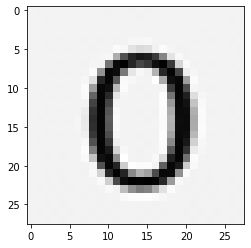

In [44]:
my_image = "digit" # change this to the name of your image file 
my_label_y = np.zeros((10,1)) # the true class of your image (1 -> cat, 0 -> non-cat)
gray_scale = [0.299, 0.587, 0.114]

my_label_y[3,0] = 1
fname = "/content/drive/MyDrive/Datasets/MNIST/" + my_image + str(2) + '.jpg'
image = np.array(plt.imread(fname))
image = np.dot(image[...,:3],gray_scale)
my_image = np.array(Image.fromarray(image).resize(size=(num_px, num_px))).reshape((num_px*num_px,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(my_image.reshape(num_px,num_px), cmap='gray')
# print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
print(f'The model predicted as digit {np.squeeze(my_predicted_image)}')

In [ ]:
my_image = np.array(Image.fromarray(image).resize(size=(num_px, num_px)))
plt.imshow(my_image)

In [ ]:
my_image = "cat_noncat" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

num_cat_px = 64

fname = "/content/drive/MyDrive/Datasets/cat_noncat/" + my_image + str(1) + '.jpg'
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize(size=(num_cat_px, num_cat_px))).reshape((num_cat_px*num_cat_px*3,1))
print(my_image.shape)
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
# print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
print(my_predicted_image)